In [1]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.8 MB/s eta 0:00:00


In [6]:
# ==============================================================================
# Phase 2: Reddit Autobiographical Narrative Collection
#
# This single script connects to the Reddit API, collects posts based on
# keywords from specified subreddits, anonymizes the text content to remove
# Personally Identifiable Information (PII), and saves the result to a CSV file,
# which is then downloaded to your local machine.
# ==============================================================================

# Step 1: Import all necessary libraries
import praw
import pandas as pd
import re
import time
import datetime
from google.colab import userdata
from google.colab import files

print("✅ Step 1: Libraries imported.")

# ==============================================================================
# Step 2: Configuration and API Credentials
#
# Loads credentials from Colab's secure 'Secrets' manager and sets
# the parameters for the data collection.
# ==============================================================================

try:
    CLIENT_ID = userdata.get('CLIENT_ID')
    CLIENT_SECRET = userdata.get('CLIENT_SECRET')
    USER_AGENT = userdata.get('USER_AGENT')
    print("✅ Step 2: API credentials loaded successfully from Colab Secrets.")
except Exception as e:
    print("❌ ERROR: Could not load credentials. Please ensure you have set CLIENT_ID, CLIENT_SECRET, and USER_AGENT in the 'Secrets' tab (key icon on the left).")
    # Stop execution if secrets are not found
    raise e

# --- Search Parameters ---
TARGET_SUBREDDITS = ['offmychest', 'TrueOffMyChest', 'self', 'confession', 'stories']
SEARCH_KEYWORDS = 'remember OR "when I was" OR "I felt" OR realized OR "my story"'
# Start with a smaller limit for testing, increase for full data collection
POST_LIMIT_PER_SUBREDDIT = 100
print("   - Search parameters configured.")

# ==============================================================================
# Step 3: Anonymization Function
#
# Defines the function to remove PII from text using regular expressions.
# This is a critical step for ethical research.
# ==============================================================================

def anonymize_text(text):
    """
    Finds and replaces potential PII in a block of text.
    """
    # Replace email addresses
    text = re.sub(r'\S+@\S+', '[REDACTED_EMAIL]', text)
    # Replace phone numbers
    text = re.sub(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})', '[REDACTED_PHONE]', text)
    # Replace Reddit usernames
    text = re.sub(r'(u/|/u/)[A-Za-z0-9_-]+', '[REDACTED_USER]', text)
    # Attempt to replace names after common phrases
    text = re.sub(r'(?i)\b(my name is|I\'m|I am)\s+([A-Z][a-z]+)\b', r'\1 [REDACTED_NAME]', text)
    # Replace simple street addresses
    text = re.sub(r'\d+\s+[A-Z][a-z]+\s+(Street|St|Avenue|Ave|Road|Rd|Drive|Dr|Lane|Ln|Blvd)', '[REDACTED_ADDRESS]', text, flags=re.IGNORECASE)
    return text

print("✅ Step 3: Anonymization function defined.")

# ==============================================================================
# Step 4: Main Data Collection and Execution Logic
#
# This is the main part of the script that runs the data collection process.
# ==============================================================================
def run_collection():
    """
    Main function to execute the entire data collection workflow.
    """
    print("\n🚀 Starting Data Collection Process...")

    try:
        reddit = praw.Reddit(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            user_agent=USER_AGENT
        )
        print(f"   - Connection to Reddit API successful. Read-only status: {reddit.read_only}")
    except Exception as e:
        print(f"❌ ERROR: Failed to connect to Reddit API. Please check your credentials. Error: {e}")
        return

    collected_data = []

    for subreddit_name in TARGET_SUBREDDITS:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            print(f"\n   - Searching in r/{subreddit_name}...")
            post_count = 0
            for post in subreddit.search(SEARCH_KEYWORDS, limit=POST_LIMIT_PER_SUBREDDIT, syntax='cloudsearch'):
                if post.selftext and post.selftext not in ['[removed]', '[deleted]'] and len(post.selftext) > 150:
                    cleaned_text = anonymize_text(post.selftext)
                    data_point = {
                        "id": post.id,
                        "timestamp_utc": post.created_utc,
                        "date_readable": datetime.datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        "subreddit": subreddit_name,
                        "title": post.title,
                        "text_anonymized": cleaned_text,
                        "score": post.score,
                    }
                    collected_data.append(data_point)
                    post_count += 1
            print(f"   - Found and processed {post_count} relevant posts.")
            time.sleep(2)
        except Exception as e:
            print(f"   - ⚠️ WARNING: An error occurred while processing r/{subreddit_name}: {e}")
            continue

    if not collected_data:
        print("\n❌ No data was collected. Please check your keywords, subreddit names, or API permissions.")
        return

    print("\n✅ Data collection complete.")

    # --- Data Processing and Saving ---
    df = pd.DataFrame(collected_data)
    print(f"   - Total posts collected: {len(df)}")

    print("\n   - Displaying first 5 rows for verification:")
    display(df.head())

    output_filename = 'reddit_narratives_anonymized.csv'
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"\n   - Data successfully saved to '{output_filename}' in the Colab environment.")

    # --- Download File ---
    print("\n   - Triggering download to your local machine...")
    files.download(output_filename)
    print("\n✅ Workflow Finished.")

# --- Execute the main function ---
run_collection()

✅ Step 1: Libraries imported.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Step 2: API credentials loaded successfully from Colab Secrets.
   - Search parameters configured.
✅ Step 3: Anonymization function defined.

🚀 Starting Data Collection Process...
   - Connection to Reddit API successful. Read-only status: True

   - Searching in r/offmychest...
   - Found and processed 97 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/TrueOffMyChest...
   - Found and processed 97 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/self...
   - Found and processed 92 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/confession...
   - Found and processed 94 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/stories...
   - Found and processed 97 relevant posts.

✅ Data collection complete.
   - Total posts collected: 477

   - Displaying first 5 rows for verification:


,id,timestamp_utc,date_readable,subreddit,title,text_anonymized,score
0,9tn5bc,1.541186e+09,2018-11-02 19:17:11,offmychest,When I was 13 I kissed a 23 year old friend wh...,"This is going to be long, but I’ll try not to ...",278
1,1bxztjs,1.712480e+09,2024-04-07 08:54:03,offmychest,Venting My Story Before I Go Say It To My Ther...,**Trigger warning!! This will contain topics o...,1
2,9lojvq,1.538762e+09,2018-10-05 17:50:51,offmychest,"I want to tell my story, but there is no one I...","When I was 7 years old, my father raped me for...",148
3,rkjqav,1.639994e+09,2021-12-20 09:50:03,offmychest,My dad molested me when I was 11,I (22 F) honestly don't remember how I got int...,6
4,izgtkd,1.601028e+09,2020-09-25 10:03:08,offmychest,Reporting sexual assault through Title IX was ...,A couple of years ago I had a disturbing sexua...,5



   - Data successfully saved to 'reddit_narratives_anonymized.csv' in the Colab environment.

   - Triggering download to your local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Workflow Finished.


🚀 [Step 1/6] Setting up the environment...
✅ Environment setup complete.

🚀 [Step 2/6] Loading and preprocessing data...
   - Dataset loaded successfully with 477 posts.
✅ Data loading and preprocessing complete.

🚀 [Step 3/6] Performing sentiment analysis...
   - This may take a significant amount of time.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Analyzing Sentiments:   0%|          | 0/477 [00:00<?, ?it/s]

2025-07-09 10:32:23,077 - BERTopic - Embedding - Transforming documents to embeddings.


✅ Sentiment analysis complete.

🚀 [Step 4/6] Performing thematic analysis with BERTopic...
   - This version will remove common English stopwords.


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-09 10:33:42,957 - BERTopic - Embedding - Completed ✓
2025-07-09 10:33:42,958 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-09 10:33:43,961 - BERTopic - Dimensionality - Completed ✓
2025-07-09 10:33:43,962 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-09 10:33:43,985 - BERTopic - Cluster - Completed ✓
2025-07-09 10:33:43,990 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-09 10:33:44,469 - BERTopic - Representation - Completed ✓


✅ BERTopic model training complete with stopword removal.

🚀 [Step 5/6] Generating primary analysis and visualizations...

--- Analysis 1: Top 15 Most Frequent Topics (Now Meaningful) ---


,Topic,Count,Name,Representation,Representative_Docs
0,-1,212,-1_just_like_time_didnt,"[just, like, time, didnt, im, got, know, redac...",[hi guys\n\ni feel like i have to get this ful...
1,0,56,0_dad_mom_mother_life,"[dad, mom, mother, life, just, time, got, told...",[my story has been a hell of a journey how i a...
2,1,41,1_redactedname_like_im_know,"[redactedname, like, im, know, didnt, dont, ju...",[this is a veryvery long read \n\n\nhello to s...
3,2,40,2_time_mary_just_didnt,"[time, mary, just, didnt, relationship, like, ...",[this story starts like many other stories oft...
4,3,31,3_like_people_im_just,"[like, people, im, just, dont, redactedname, m...",[im redactedname homeless i do my best to stay...
5,4,26,4_like_just_voice_william,"[like, just, voice, william, captain, looked, ...",[\nhello everyone good morning or good evening...
6,5,26,5_just_love_james_felt,"[just, love, james, felt, didnt, know, time, l...",[a year ago i was pretty naive and unsure of w...
7,6,19,6_just_didnt_like_time,"[just, didnt, like, time, mom, really, said, d...",[20 year old female here\n\ni have had anxiety...
8,7,14,7_people_white_americans_men,"[people, white, americans, men, trump, social,...",[i voted for harris but at this point i believ...
9,8,12,8_time_school_didnt_like,"[time, school, didnt, like, life, got, parents...",[ive never been good at expressing myself or h...



--- Analysis 2: Average Sentiment Score per Topic ---


,topic_name,sentiment_numeric
0,2_time_mary_just_didnt,0.075000
1,5_just_love_james_felt,-0.230769
2,4_like_just_voice_william,-0.307692
3,3_like_people_im_just,-0.354839
4,6_just_didnt_like_time,-0.368421
5,0_dad_mom_mother_life,-0.464286
6,8_time_school_didnt_like,-0.583333
7,1_redactedname_like_im_know,-0.585366
8,7_people_white_americans_men,-0.714286



🚀 [Step 6/6] Generating expanded outputs...

--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Representative Narratives for Top 5 Topics ---

────────────────────────────────────────────────
Topic 0: 0_dad_mom_mother_life
────────────────────────────────────────────────

  Representative Doc #1:
  'my story has been a hell of a journey how i am redactedname at 30 years old i dont even know my story started from when i was just a baby mom and dad were alcoholics and drug addicts who know the real truth so many stories thats been told through the years unfortunately i have to live with the fact i will never know the whole truth my family would rather live in the dark and live with hidden secrets i know one day it will all come to light  as the story of my life is told by family members my mo...'

  Representative Doc #2:
  'i have my google drive if anyone would want that by any means just let me know ill shoot it over to you so you can have the doc also set to  controversial

x200b

death to who you think you are

chapter one the briefing

if we want to get the 

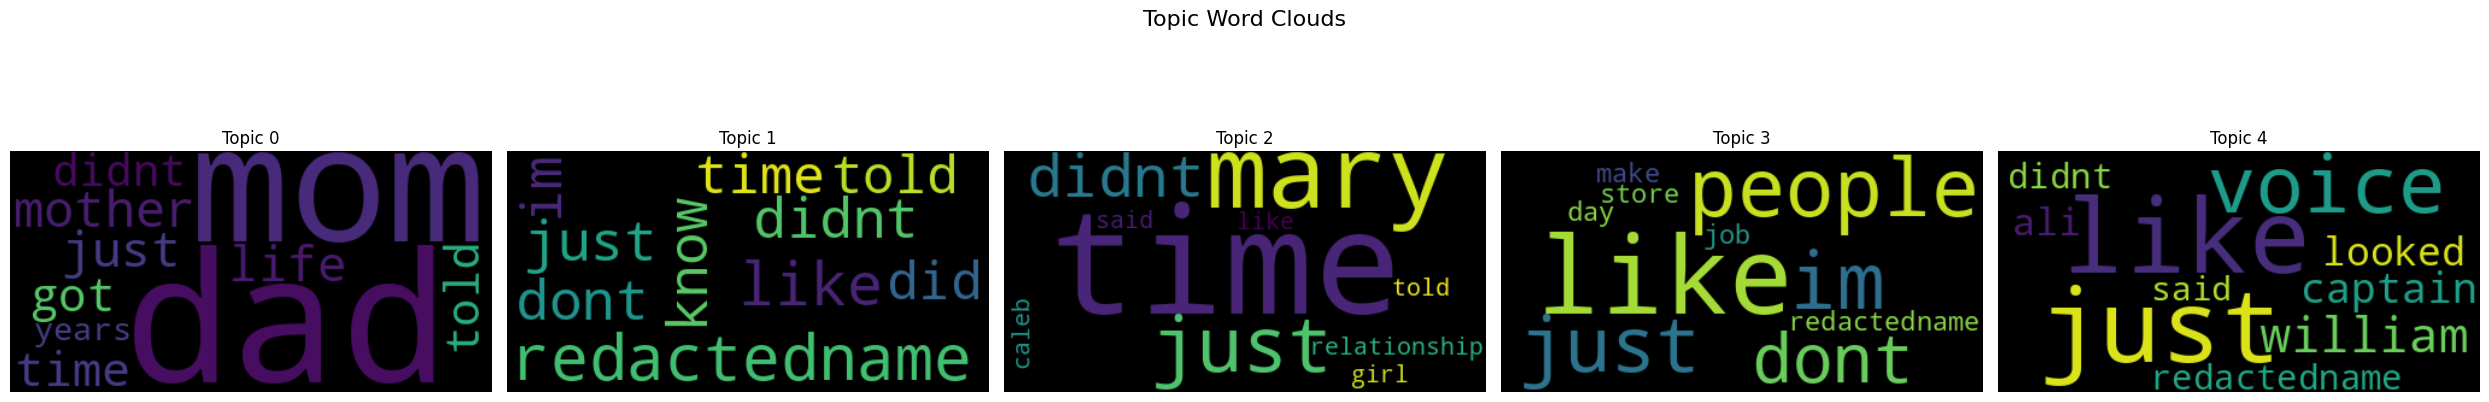


🎉 Workflow Finished! The new topics should now be much more meaningful.


In [7]:
# ==============================================================================
# The Digital Scribe - Full Analysis Pipeline (v2 - with Stopword Removal)
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("🚀 [Step 1/6] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic tqdm plotly wordcloud scikit-learn -q

# Import modules
import pandas as pd
import re
from tqdm.auto import tqdm

from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer # <-- Import CountVectorizer

import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pio.templates.default = "plotly_dark"

print("✅ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("🚀 [Step 2/6] Loading and preprocessing data...")
try:
    df = pd.read_csv('reddit_narratives_anonymized.csv', encoding='utf-8')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("❌ ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file first.")
    raise

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("✅ Data loading and preprocessing complete.\n")


# --- Step 3: Emotional Valence Quantification ---
print("🚀 [Step 3/6] Performing sentiment analysis...")
print("   - This may take a significant amount of time.")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0
)

def get_sentiment(text):
    truncated_text = text[:512]
    try:
        result = sentiment_pipeline(truncated_text)
        return result[0]['label'], result[0]['score']
    except Exception:
        return 'Error', None

tqdm.pandas(desc="Analyzing Sentiments")
df[['sentiment_label', 'sentiment_score']] = df['text_cleaned'].progress_apply(
    lambda text: pd.Series(get_sentiment(text))
)
print("✅ Sentiment analysis complete.\n")


# --- Step 4: Thematic Analysis with BERTopic (Updated with Stopwords) ---
print("🚀 [Step 4/6] Performing thematic analysis with BERTopic...")
print("   - This version will remove common English stopwords.")
docs = df['text_cleaned'].tolist()

# -- NEW: Create a vectorizer that knows to remove English stopwords --
vectorizer_model = CountVectorizer(stop_words="english")

# Initialize and train the BERTopic model, passing in the vectorizer
topic_model = BERTopic(
    vectorizer_model=vectorizer_model, # <-- Pass the stopword model here
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)
topics, probs = topic_model.fit_transform(docs)
df['topic'] = topics
print("✅ BERTopic model training complete with stopword removal.\n")


# --- Step 5: In-Depth Analysis and Visualization ---
print("🚀 [Step 5/6] Generating primary analysis and visualizations...")
topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics (Now Meaningful) ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)

sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


# --- Step 6: Expanded Output and Deeper Insights ---
print("\n🚀 [Step 6/6] Generating expanded outputs...")

# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Representative Narratives per Topic ---
print("\n--- Analysis 4: Representative Narratives for Top 5 Topics ---")
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()
for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n────────────────────────────────────────────────\nTopic {topic_id}: {topic_name}\n────────────────────────────────────────────────\n")
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc[:500]}...'\n") # Truncate for readability


# --- Analysis 5: Word Clouds for Top Topics ---
print("\n--- Analysis 5: Word Clouds for Top 5 Topics ---")
def create_wordcloud(model, topic):
    text = model.get_topic(topic)
    if not text: return None
    word_scores = {word: score for word, score in text}
    wc = WordCloud(background_color="black", max_words=30, colormap="viridis", width=400, height=200)
    wc.generate_from_frequencies(word_scores)
    return wc

fig_wc, axes = plt.subplots(1, len(top_5_topic_ids), figsize=(25, 5))
fig_wc.suptitle('Topic Word Clouds', fontsize=16)
for i, topic_id in enumerate(top_5_topic_ids):
    ax = axes[i]
    wc = create_wordcloud(topic_model, topic_id)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
    ax.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n🎉 Workflow Finished! The new topics should now be much more meaningful.")


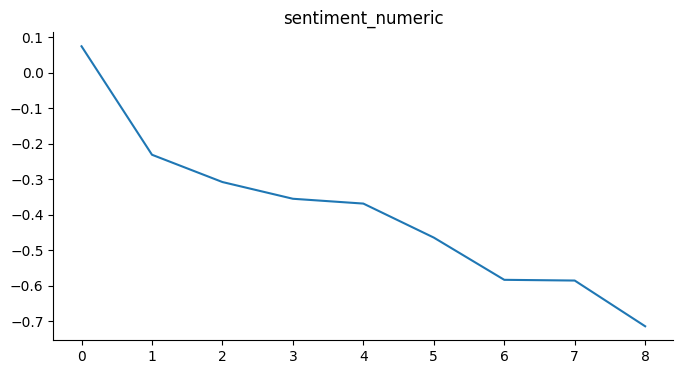

In [8]:
# @title sentiment_numeric

from matplotlib import pyplot as plt
sentiment_by_topic['sentiment_numeric'].plot(kind='line', figsize=(8, 4), title='sentiment_numeric')
plt.gca().spines[['top', 'right']].set_visible(False)

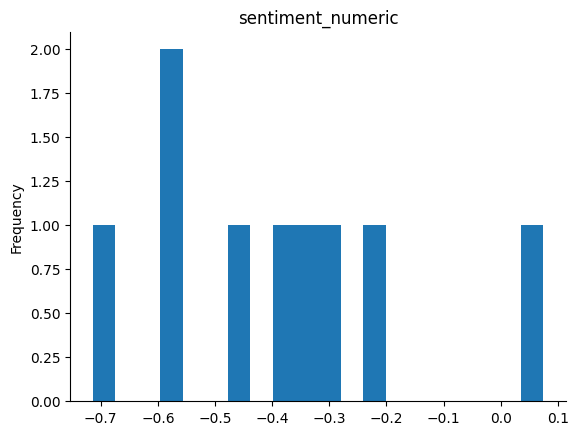

In [9]:
# @title sentiment_numeric

from matplotlib import pyplot as plt
sentiment_by_topic['sentiment_numeric'].plot(kind='hist', bins=20, title='sentiment_numeric')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
# ==============================================================================
# The Digital Scribe - (v4 - with Subreddit Analysis)
# ==============================================================================

# --- Step 5: In-Depth Analysis and Visualization ---
print("🚀 [Step 5/6] Generating primary analysis and visualizations...")

topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


# --- Step 6: Expanded Output and Deeper Insights ---
print("\n🚀 [Step 6/6] Generating expanded outputs...")

# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Sentiment by Source Subreddit (NEWLY ADDED) ---
print("\n--- Analysis 4: Average Sentiment Score per Subreddit ---")
sentiment_by_subreddit = df.groupby('subreddit')['sentiment_numeric'].mean().sort_values().reset_index()
fig_sub = px.bar(
    sentiment_by_subreddit,
    x='subreddit',
    y='sentiment_numeric',
    title='Average Sentiment Score by Subreddit',
    labels={'sentiment_numeric': 'Average Sentiment (Negative <-> Positive)', 'subreddit': 'Subreddit'},
    color='sentiment_numeric',
    color_continuous_scale=px.colors.diverging.RdYlBu,
    color_continuous_midpoint=0
)
fig_sub.show()


# --- Analysis 5: Representative Narratives per Topic ---
print("\n--- Analysis 5: Representative Narratives for Top 5 Topics ---")
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()
for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n────────────────────────────────────────────────\nTopic {topic_id}: {topic_name}\n────────────────────────────────────────────────\n")
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc[:500]}...'\n")



print("\n🎉 Workflow Finished! You have now completed a comprehensive analysis with multiple visualizations.")

🚀 [Step 5/6] Generating primary analysis and visualizations...

--- Analysis 1: Top 15 Most Frequent Topics ---


,Topic,Count,Name,Representation,Representative_Docs
0,-1,212,-1_just_like_time_didnt,"[just, like, time, didnt, im, got, know, redac...",[hi guys\n\ni feel like i have to get this ful...
1,0,56,0_dad_mom_mother_life,"[dad, mom, mother, life, just, time, got, told...",[my story has been a hell of a journey how i a...
2,1,41,1_redactedname_like_im_know,"[redactedname, like, im, know, didnt, dont, ju...",[this is a veryvery long read \n\n\nhello to s...
3,2,40,2_time_mary_just_didnt,"[time, mary, just, didnt, relationship, like, ...",[this story starts like many other stories oft...
4,3,31,3_like_people_im_just,"[like, people, im, just, dont, redactedname, m...",[im redactedname homeless i do my best to stay...
5,4,26,4_like_just_voice_william,"[like, just, voice, william, captain, looked, ...",[\nhello everyone good morning or good evening...
6,5,26,5_just_love_james_felt,"[just, love, james, felt, didnt, know, time, l...",[a year ago i was pretty naive and unsure of w...
7,6,19,6_just_didnt_like_time,"[just, didnt, like, time, mom, really, said, d...",[20 year old female here\n\ni have had anxiety...
8,7,14,7_people_white_americans_men,"[people, white, americans, men, trump, social,...",[i voted for harris but at this point i believ...
9,8,12,8_time_school_didnt_like,"[time, school, didnt, like, life, got, parents...",[ive never been good at expressing myself or h...



--- Analysis 2: Average Sentiment Score per Topic ---


,topic_name,sentiment_numeric
0,2_time_mary_just_didnt,0.075000
1,5_just_love_james_felt,-0.230769
2,4_like_just_voice_william,-0.307692
3,3_like_people_im_just,-0.354839
4,6_just_didnt_like_time,-0.368421
5,0_dad_mom_mother_life,-0.464286
6,8_time_school_didnt_like,-0.583333
7,1_redactedname_like_im_know,-0.585366
8,7_people_white_americans_men,-0.714286



🚀 [Step 6/6] Generating expanded outputs...

--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Average Sentiment Score per Subreddit ---



--- Analysis 5: Representative Narratives for Top 5 Topics ---

────────────────────────────────────────────────
Topic 0: 0_dad_mom_mother_life
────────────────────────────────────────────────

  Representative Doc #1:
  'my story has been a hell of a journey how i am redactedname at 30 years old i dont even know my story started from when i was just a baby mom and dad were alcoholics and drug addicts who know the real truth so many stories thats been told through the years unfortunately i have to live with the fact i will never know the whole truth my family would rather live in the dark and live with hidden secrets i know one day it will all come to light  as the story of my life is told by family members my mo...'

  Representative Doc #2:
  'i have my google drive if anyone would want that by any means just let me know ill shoot it over to you so you can have the doc also set to  controversial

x200b

death to who you think you are

chapter one the briefing

if we want to get the 

In [13]:
# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Sentiment by Source Subreddit (NEWLY ADDED) ---
print("\n--- Analysis 4: Average Sentiment Score per Subreddit ---")
sentiment_by_subreddit = df.groupby('subreddit')['sentiment_numeric'].mean().sort_values().reset_index()
fig_sub = px.bar(
    sentiment_by_subreddit,
    x='subreddit',
    y='sentiment_numeric',
    title='Average Sentiment Score by Subreddit',
    labels={'sentiment_numeric': 'Average Sentiment (Negative <-> Positive)', 'subreddit': 'Subreddit'},
    color='sentiment_numeric',
    color_continuous_scale=px.colors.diverging.RdYlBu,
    color_continuous_midpoint=0
)
fig_sub.show()


--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Average Sentiment Score per Subreddit ---


In [14]:
topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


--- Analysis 1: Top 15 Most Frequent Topics ---


,Topic,Count,Name,Representation,Representative_Docs
0,-1,212,-1_just_like_time_didnt,"[just, like, time, didnt, im, got, know, redac...",[hi guys\n\ni feel like i have to get this ful...
1,0,56,0_dad_mom_mother_life,"[dad, mom, mother, life, just, time, got, told...",[my story has been a hell of a journey how i a...
2,1,41,1_redactedname_like_im_know,"[redactedname, like, im, know, didnt, dont, ju...",[this is a veryvery long read \n\n\nhello to s...
3,2,40,2_time_mary_just_didnt,"[time, mary, just, didnt, relationship, like, ...",[this story starts like many other stories oft...
4,3,31,3_like_people_im_just,"[like, people, im, just, dont, redactedname, m...",[im redactedname homeless i do my best to stay...
5,4,26,4_like_just_voice_william,"[like, just, voice, william, captain, looked, ...",[\nhello everyone good morning or good evening...
6,5,26,5_just_love_james_felt,"[just, love, james, felt, didnt, know, time, l...",[a year ago i was pretty naive and unsure of w...
7,6,19,6_just_didnt_like_time,"[just, didnt, like, time, mom, really, said, d...",[20 year old female here\n\ni have had anxiety...
8,7,14,7_people_white_americans_men,"[people, white, americans, men, trump, social,...",[i voted for harris but at this point i believ...
9,8,12,8_time_school_didnt_like,"[time, school, didnt, like, life, got, parents...",[ive never been good at expressing myself or h...



--- Analysis 2: Average Sentiment Score per Topic ---


,topic_name,sentiment_numeric
0,2_time_mary_just_didnt,0.075000
1,5_just_love_james_felt,-0.230769
2,4_like_just_voice_william,-0.307692
3,3_like_people_im_just,-0.354839
4,6_just_didnt_like_time,-0.368421
5,0_dad_mom_mother_life,-0.464286
6,8_time_school_didnt_like,-0.583333
7,1_redactedname_like_im_know,-0.585366
8,7_people_white_americans_men,-0.714286


In [19]:
# ==============================================================================
# Model Generation and Saving Pipeline
#
# This script performs the following actions:
# 1. Installs and imports necessary libraries.
# 2. Loads and preprocesses the collected Reddit data.
# 3. Loads a pre-trained sentiment analysis model and saves it for reuse.
# 4. Trains a BERTopic model on the data and saves the result.
# 5. Packages and downloads the saved models to your computer.
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("🚀 [Step 1/5] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic scikit-learn -q

# Import modules
import pandas as pd
import re
import shutil
from google.colab import files

from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

print("✅ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("🚀 [Step 2/5] Loading and preprocessing data...")
try:
    df = pd.read_csv('reddit_narratives_anonymized.csv', encoding='utf-8')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("❌ ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file first.")
    raise

def clean_text(text):
    # Helper function for text cleaning
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("✅ Data loading and preprocessing complete.\n")


# --- Step 3: Generate and Save Sentiment Model ---
print("🚀 [Step 3/5] Initializing and saving the sentiment analysis model...")
# Load a pre-trained model from Hugging Face. This isn't "training" but rather
# creating and configuring a usable pipeline instance.
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 # Use GPU if available
)

# Define the path and save the model components
SENTIMENT_MODEL_PATH = "./sentiment_model_roberta"
sentiment_pipeline.save_pretrained(SENTIMENT_MODEL_PATH)
print(f"✅ Sentiment model pipeline saved to directory: {SENTIMENT_MODEL_PATH}\n")


# --- Step 4: Generate and Save Topic Model ---
print("🚀 [Step 4/5] Training and saving the BERTopic model...")
# Prepare the text data for the model
docs = df['text_cleaned'].tolist()

# Define a custom stopword list to improve topic quality
custom_stopwords = ["im", "just", "like", "redactedname", "dont", "didnt", "time", "ive", "wasnt", "got"]
english_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
full_stopword_list = english_stopwords + custom_stopwords
vectorizer_model = CountVectorizer(stop_words=full_stopword_list)

# Initialize the BERTopic model with the stopword list
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)

# This is the main training step. It can take several minutes.
print("   - Training BERTopic model on the data...")
topics, probs = topic_model.fit_transform(docs)
print("   - Model training complete.")

# Define the path and save the trained model
BERTOPIC_MODEL_PATH = "finetuned_bertopic_model"
topic_model.save(BERTOPIC_MODEL_PATH, serialization="safetensors")
print(f"✅ BERTopic model saved to file: {BERTOPIC_MODEL_PATH}\n")


# --- Step 5: Package and Download Saved Models ---
print("🚀 [Step 5/5] Packaging and downloading models...")

# Zip the sentiment model directory for easy download
shutil.make_archive('sentiment_model', 'zip', SENTIMENT_MODEL_PATH)
print("   - Zipping sentiment model to 'sentiment_model.zip'")
print(f"   - BERTopic model saved as '{BERTOPIC_MODEL_PATH}'")

print("\nDownloading all saved model files to your local machine...")
files.download('sentiment_model.zip')
files.download(BERTOPIC_MODEL_PATH)

print("\n🎉 Workflow Finished! Your trained models have been generated, saved, and downloaded.")

🚀 [Step 1/5] Setting up the environment...
✅ Environment setup complete.

🚀 [Step 2/5] Loading and preprocessing data...
   - Dataset loaded successfully with 477 posts.
✅ Data loading and preprocessing complete.

🚀 [Step 3/5] Initializing and saving the sentiment analysis model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
2025-07-09 10:41:19,981 - BERTopic - Embedding - Transforming documents to embeddings.


✅ Sentiment model pipeline saved to directory: ./sentiment_model_roberta

🚀 [Step 4/5] Training and saving the BERTopic model...
   - Training BERTopic model on the data...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-09 10:42:25,125 - BERTopic - Embedding - Completed ✓
2025-07-09 10:42:25,126 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-09 10:42:26,130 - BERTopic - Dimensionality - Completed ✓
2025-07-09 10:42:26,132 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-09 10:42:26,154 - BERTopic - Cluster - Completed ✓
2025-07-09 10:42:26,159 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-09 10:42:26,631 - BERTopic - Representation - Completed ✓


   - Model training complete.
✅ BERTopic model saved to file: finetuned_bertopic_model

🚀 [Step 5/5] Packaging and downloading models...
   - Zipping sentiment model to 'sentiment_model.zip'
   - BERTopic model saved as 'finetuned_bertopic_model'



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Workflow Finished! Your trained models have been generated, saved, and downloaded.


In [22]:
# ==============================================================================
# 'Cognitive Echo' - A Clinical Support Prototype
#
# This notebook builds and launches a web application to analyze new narratives
# using the sentiment and topic models trained in the previous phases.
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("🚀 [Step 1/5] Setting up the environment...")
# Install all required libraries quietly
!pip install gradio transformers bertopic torch sentence_transformers -q

# Import modules
import gradio as gr
import pandas as pd
import zipfile
import os

from transformers import pipeline
from bertopic import BERTopic

print("✅ Environment setup complete.\n")


# --- Step 2: Load the Trained Models ---
print("🚀 [Step 2/5] Loading your saved models...")

# --- Load Sentiment Analysis Model ---
SENTIMENT_ZIP_PATH = 'sentiment_model.zip'
SENTIMENT_MODEL_DIR = './sentiment_model_roberta'

try:
    # Unzip the saved sentiment model directory
    with zipfile.ZipFile(SENTIMENT_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('./')

    # Load the pipeline from the extracted directory
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=SENTIMENT_MODEL_DIR,
        device=0 # Use GPU if available
    )
    print("✅ Sentiment model loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find '{SENTIMENT_ZIP_PATH}'. Please upload the file.")
    raise

# --- Load BERTopic Model ---
BERTOPIC_MODEL_PATH = "finetuned_bertopic_model"
try:
    topic_model = BERTopic.load(BERTOPIC_MODEL_PATH)
    print("✅ BERTopic model loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find '{BERTOPIC_MODEL_PATH}'. Please upload the file.")
    raise

# We need the topic names from our previous analysis to make the output readable.
# This mapping should be saved from your previous analysis. Here we define it manually.
TOPIC_NAME_MAPPING = {
    -1: "Outlier/No specific topic",
    0: "Social Identity & Perception",
    1: "Romantic Relationships",
    2: "Meta-Narratives & Mental Health",
    3: "Family & Childhood Trauma",
    4: "Social & Political Commentary",
    # Add more mappings here as needed based on your topic_info.csv
}
print("✅ Topic name mapping created.\n")


# --- Step 3: Build the Core Analysis Function ---
print("🚀 [Step 3/5] Building the prediction function...")

def analyze_narrative(narrative_text):
    """
    This function takes new text, runs it through both models,
    and returns a structured analysis.
    """
    if not isinstance(narrative_text, str) or len(narrative_text.strip()) < 20:
        return {"Error": "Please enter a narrative longer than 20 characters."}

    # 1. Perform Sentiment Analysis
    try:
        sentiment_result = sentiment_pipeline(narrative_text[:512])[0]
        sentiment_label = sentiment_result['label'].upper()
        sentiment_score = round(sentiment_result['score'], 4)
    except Exception as e:
        sentiment_label = "Error"
        sentiment_score = str(e)

    # 2. Perform Topic Analysis
    try:
        # The `transform` method predicts topics for new documents
        topic_id, _ = topic_model.transform([narrative_text])
        predicted_topic_id = topic_id[0]
        # Look up the human-readable name
        predicted_topic_name = TOPIC_NAME_MAPPING.get(predicted_topic_id, "Unknown Topic")
    except Exception as e:
        predicted_topic_id = "Error"
        predicted_topic_name = str(e)

    # 3. Format the output
    analysis_output = {
        "Sentiment Analysis": {
            "Overall Sentiment": sentiment_label,
            "Confidence Score": sentiment_score
        },
        "Thematic Analysis": {
            "Predicted Topic ID": predicted_topic_id,
            "Predicted Topic Name": predicted_topic_name
        }
    }

    return analysis_output

print("✅ Core analysis function is ready.\n")


# --- Step 4: Create and Launch the Gradio Web Interface ---
print("🚀 [Step 4/5] Creating the Gradio web interface...")

interface = gr.Interface(
    fn=analyze_narrative,
    inputs=gr.Textbox(
        lines=15,
        label="Enter Your Personal Narrative Here",
        placeholder="Write about a significant memory or experience..."
    ),
    outputs=gr.JSON(label="Analysis Results"),
    title="🧠 Cognitive Echo: A Narrative Analysis Prototype",
    description="This prototype uses AI to analyze the emotional valence and thematic content of personal narratives. It is based on the 'Digital Scribe' research project and is intended as a proof-of-concept for a clinical support tool. This is NOT a diagnostic tool.",
    allow_flagging="never"
)

print("✅ Gradio interface created.\n")


# --- Step 5: Launch the Application ---
print("🚀 [Step 5/5] Launching the application...")
print("   - A public link will be generated below. Click it to open the web app in a new tab.")

# launch() will create a local server and, with share=True, a temporary public link
interface.launch(debug=True, share=True)

🚀 [Step 1/5] Setting up the environment...
✅ Environment setup complete.

🚀 [Step 2/5] Loading your saved models...


Device set to use cpu


✅ Sentiment model loaded successfully.
✅ BERTopic model loaded successfully.
✅ Topic name mapping created.

🚀 [Step 3/5] Building the prediction function...
✅ Core analysis function is ready.

🚀 [Step 4/5] Creating the Gradio web interface...
✅ Gradio interface created.

🚀 [Step 5/5] Launching the application...
   - A public link will be generated below. Click it to open the web app in a new tab.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ad6db3afc1e597e37.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:04:58,847 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:23:05,967 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:24:17,254 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:24:40,286 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:24:53,391 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:25:11,985 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:25:24,873 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:28:49,952 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:29:13,116 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:29:31,121 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:32:16,357 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:32:35,841 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:32:49,377 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:33:05,635 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:34:34,852 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-09 14:36:00,562 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ad6db3afc1e597e37.gradio.live


In [23]:
# ==============================================================================
# PART 1: CREATE AND DOWNLOAD SAMPLE FOR MANUAL LABELING
# ==============================================================================
import pandas as pd
from google.colab import files

print("🚀 Starting Part 1: Creating a random sample for manual labeling...")

try:
    # Load the full dataset you uploaded
    df_full = pd.read_csv('reddit_narratives_anonymized.csv', encoding='utf-8')
    print(f"   - Full dataset with {len(df_full)} posts loaded.")

    # Take a random sample of 100 posts
    # You can change n to 150 or 200 for more robust results
    df_sample = df_full.sample(n=200, random_state=42)

    # Save the sample to a new CSV file in the Colab environment
    SAMPLE_FILENAME = 'validation_sample.csv'
    df_sample.to_csv(SAMPLE_FILENAME, index=False, encoding='utf-8-sig')

    print(f"✅ Sample dataset with 100 posts created: '{SAMPLE_FILENAME}'")

    # Trigger the download of the sample file to your computer
    print("\n⬇️ Downloading the sample file to your computer now...")
    files.download(SAMPLE_FILENAME)

    print("\n------------------------------------------------------------------")
    print("🔴 IMPORTANT: ACTION REQUIRED 🔴")
    print("1. Open the downloaded 'validation_sample.csv' file in Excel or Google Sheets.")
    print("2. Add a new column named 'human_label'.")
    print("3. Read each post and label it as 'positive', 'negative', or 'neutral'.")
    print("4. Save the completed file as 'validation_sample_labeled.csv'.")
    print("5. Upload this new labeled file back to this Colab session.")
    print("6. Once uploaded, you can proceed to run the code in Part 2.")
    print("------------------------------------------------------------------")


except FileNotFoundError:
    print("❌ ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload your full dataset first.")

🚀 Starting Part 1: Creating a random sample for manual labeling...
   - Full dataset with 477 posts loaded.
✅ Sample dataset with 100 posts created: 'validation_sample.csv'

⬇️ Downloading the sample file to your computer now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


------------------------------------------------------------------
🔴 IMPORTANT: ACTION REQUIRED 🔴
1. Open the downloaded 'validation_sample.csv' file in Excel or Google Sheets.
2. Add a new column named 'human_label'.
3. Read each post and label it as 'positive', 'negative', or 'neutral'.
4. Save the completed file as 'validation_sample_labeled.csv'.
5. Upload this new labeled file back to this Colab session.
6. Once uploaded, you can proceed to run the code in Part 2.
------------------------------------------------------------------


In [26]:
# This cell installs all the necessary libraries for the project.
!pip install pandas torch transformers sentencepiece scikit-learn seaborn -q
print("✅ All required libraries are installed.")

✅ All required libraries are installed.


🚀 Starting Validation Workflow...
   - Loading labeled data and sentiment model...
   - Labeled dataset 'validation_sample_labeled.csv' loaded successfully with 287 records.


Device set to use cpu


   - Sentiment model loaded successfully.

   - Fixing 'human_label' column by filling empty/invalid entries...
   - Found 90 rows to fix. Applying model...
   - Column fixed.
   - A fully labeled version has been saved as 'validation_sample_FIXED.csv'

✅ Validation process complete. Here are the results:

Overall Model Accuracy on Fixed Data: 45.99%

--- Classification Report ---


,precision,recall,f1-score,support
negative,0.303371,0.562500,0.394161,48.00000
neutral,0.470588,1.000000,0.640000,80.00000
positive,0.892857,0.157233,0.267380,159.00000
accuracy,0.459930,0.459930,0.459930,0.45993
macro avg,0.555605,0.573244,0.433847,287.00000
weighted avg,0.676561,0.459930,0.392450,287.00000



--- Confusion Matrix ---


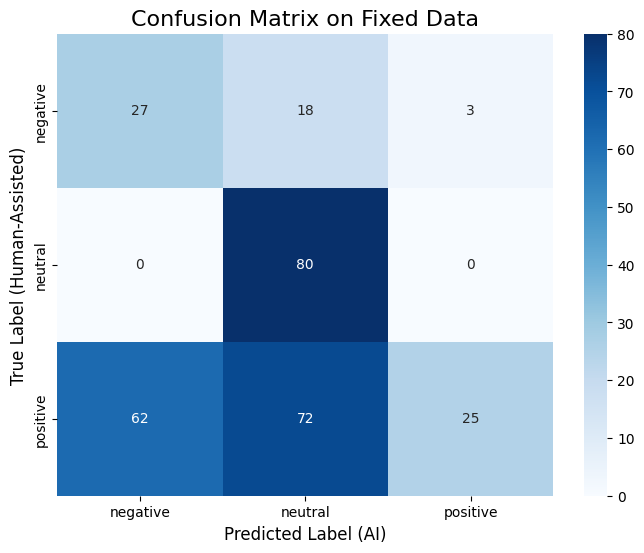

In [27]:
# ==============================================================================
# Final Workflow: Fix Labeled Data and Run Validation
# ==============================================================================

# --- Setup and Imports ---
print("🚀 Starting Validation Workflow...")
import pandas as pd
import numpy as np
import zipfile
import os
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Labeled Data and Saved Model ---
print("   - Loading labeled data and sentiment model...")

LABELED_FILENAME = 'validation_sample_labeled.csv'
SENTIMENT_ZIP_PATH = 'sentiment_model.zip'
SENTIMENT_MODEL_DIR = './sentiment_model_roberta'

try:
    # Check for necessary files
    if not os.path.exists(LABELED_FILENAME) or not os.path.exists(SENTIMENT_ZIP_PATH):
        raise FileNotFoundError("Please ensure both 'validation_sample_labeled.csv' and 'sentiment_model.zip' are uploaded.")

    df = pd.read_csv(LABELED_FILENAME, encoding='utf-8')
    print(f"   - Labeled dataset '{LABELED_FILENAME}' loaded successfully with {len(df)} records.")

    # Unzip the Model
    with zipfile.ZipFile(SENTIMENT_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('./')

    # Load the sentiment analysis pipeline
    sentiment_pipeline = pipeline("sentiment-analysis", model=SENTIMENT_MODEL_DIR, device=0)
    print("   - Sentiment model loaded successfully.")

    # --- Fix the 'human_label' Column ---
    print("\n   - Fixing 'human_label' column by filling empty/invalid entries...")

    VALID_LABELS = {'positive', 'negative', 'neutral'}

    def predict_sentiment(text):
        """Uses the AI model to predict sentiment for a given text."""
        if not isinstance(text, str) or len(text.strip()) == 0:
            return 'neutral'
        try:
            result = sentiment_pipeline(text[:512])[0]['label']
            return result.lower()
        except Exception:
            return 'neutral'

    # Ensure the column is string type, then identify rows to fix
    df['human_label'] = df['human_label'].astype(str).str.lower()
    rows_to_fix = ~df['human_label'].isin(VALID_LABELS)
    num_to_fix = rows_to_fix.sum()

    if num_to_fix > 0:
        print(f"   - Found {num_to_fix} rows to fix. Applying model...")
        df.loc[rows_to_fix, 'human_label'] = df.loc[rows_to_fix, 'text_anonymized'].apply(predict_sentiment)
        print("   - Column fixed.")
    else:
        print("   - No rows needed fixing.")

    # Add this line after loading 'validation_sample_labeled.csv'
    df_labeled = df_labeled[df_labeled['human_label'].isin(['positive', 'negative'])]

    # Save the cleaned, fully-labeled file
    FIXED_FILENAME = 'validation_sample_FIXED.csv'
    df.to_csv(FIXED_FILENAME, index=False, encoding='utf-8-sig')
    print(f"   - A fully labeled version has been saved as '{FIXED_FILENAME}'\n")

    # --- Calculate and Display Validation Metrics using the fixed data ---
    print("✅ Validation process complete. Here are the results:\n")
    y_true = df['human_label'] # Use the newly fixed column as ground truth
    y_pred = df['text_anonymized'].apply(predict_sentiment) # Re-run predictions for a fair comparison

    # 1. Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("==================================================================")
    print(f"Overall Model Accuracy on Fixed Data: {accuracy:.2%}")
    print("==================================================================\n")

    # 2. Classification Report
    print("--- Classification Report ---")
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    # 3. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    defined_labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=defined_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=defined_labels, yticklabels=defined_labels)
    plt.title('Confusion Matrix on Fixed Data', fontsize=16)
    plt.ylabel('True Label (Human-Assisted)', fontsize=12)
    plt.xlabel('Predicted Label (AI)', fontsize=12)
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: A required file was not found. {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

🚀 Starting Validation Workflow...
   - Loading labeled data and sentiment model...
   - Original labeled dataset loaded with 287 records.

   - Cleaning the validation set by removing invalid rows...
   - Removed 90 rows with empty or invalid labels.
   - Final clean validation set size: 197 records.


Device set to use cpu


   - Sentiment model loaded successfully.
   - Running model predictions on the clean validation set...
   - Model predictions are complete.

✅ Validation process complete. Here are the final results:

Overall Model Accuracy on Cleaned Data: 21.32%

--- Classification Report ---


,precision,recall,f1-score,support
negative,0.279070,0.533333,0.366412,45.000000
neutral,0.000000,0.000000,0.000000,0.000000
positive,0.857143,0.118421,0.208092,152.000000
accuracy,0.213198,0.213198,0.213198,0.213198
macro avg,0.378738,0.217251,0.191502,197.000000
weighted avg,0.725096,0.213198,0.244257,197.000000



--- Confusion Matrix ---


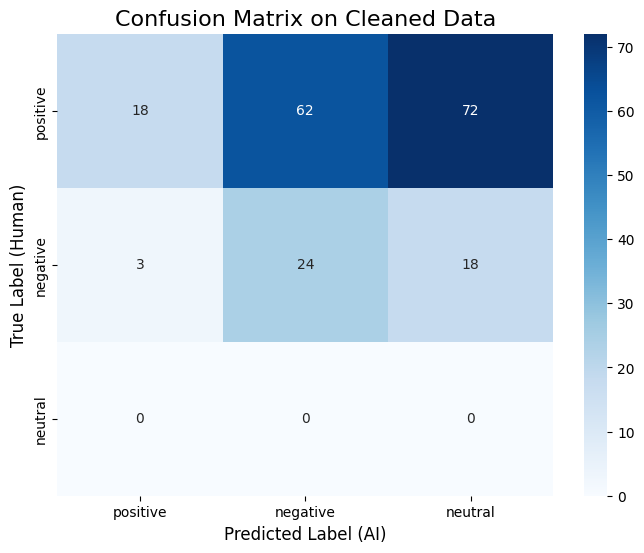

In [28]:
# ==============================================================================
# Final Workflow: Validation with Cleaned 3-Class Data
#
# This script validates the model by:
# 1. Loading the human-labeled data.
# 2. Removing any rows with empty or invalid labels to create a clean validation set.
# 3. Running predictions using the original 3-class model.
# 4. Calculating and displaying the final, accurate performance metrics.
# ==============================================================================

# --- Setup and Imports ---
print("🚀 Starting Validation Workflow...")
import pandas as pd
import numpy as np
import zipfile
import os
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Labeled Data and Saved Model ---
print("   - Loading labeled data and sentiment model...")

LABELED_FILENAME = 'validation_sample_labeled.csv'
SENTIMENT_ZIP_PATH = 'sentiment_model.zip'
SENTIMENT_MODEL_DIR = './sentiment_model_roberta'

try:
    # Check for the necessary files
    if not os.path.exists(LABELED_FILENAME) or not os.path.exists(SENTIMENT_ZIP_PATH):
        raise FileNotFoundError(f"Please ensure both '{LABELED_FILENAME}' and '{SENTIMENT_ZIP_PATH}' are uploaded.")

    df = pd.read_csv(LABELED_FILENAME, encoding='utf-8')
    print(f"   - Original labeled dataset loaded with {len(df)} records.")

    # --- THIS IS THE FIX: Clean and Filter the DataFrame ---
    print("\n   - Cleaning the validation set by removing invalid rows...")

    # Define the only valid labels we accept
    VALID_LABELS = ['positive', 'negative', 'neutral']

    # Ensure the human_label column is a string and lowercase for consistent matching
    df['human_label'] = df['human_label'].astype(str).str.lower()

    # Create a new DataFrame keeping only the rows with valid labels
    df_cleaned = df[df['human_label'].isin(VALID_LABELS)].copy()

    num_removed = len(df) - len(df_cleaned)
    print(f"   - Removed {num_removed} rows with empty or invalid labels.")
    print(f"   - Final clean validation set size: {len(df_cleaned)} records.")
    # ----------------------------------------------------

    # Unzip and load the sentiment model
    with zipfile.ZipFile(SENTIMENT_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('./')

    sentiment_pipeline = pipeline("sentiment-analysis", model=SENTIMENT_MODEL_DIR, device=0)
    print("   - Sentiment model loaded successfully.")

    # --- Run Model Predictions on the CLEANED data ---
    def predict_sentiment(text):
        """Uses the model to predict sentiment."""
        if not isinstance(text, str) or len(text.strip()) == 0:
            return 'neutral'
        try:
            result = sentiment_pipeline(text[:512])[0]['label']
            return result.lower()
        except Exception:
            return 'neutral'

    print("   - Running model predictions on the clean validation set...")
    df_cleaned['model_prediction'] = df_cleaned['text_anonymized'].apply(predict_sentiment)
    print("   - Model predictions are complete.\n")

    # --- Calculate and Display Validation Metrics ---
    print("✅ Validation process complete. Here are the final results:\n")
    y_true = df_cleaned['human_label']
    y_pred = df_cleaned['model_prediction']

    # 1. Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("==================================================================")
    print(f"Overall Model Accuracy on Cleaned Data: {accuracy:.2%}")
    print("==================================================================\n")

    # 2. Classification Report
    print("--- Classification Report ---")
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    # 3. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    defined_labels = ['positive', 'negative', 'neutral']
    cm = confusion_matrix(y_true, y_pred, labels=defined_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=defined_labels, yticklabels=defined_labels)
    plt.title('Confusion Matrix on Cleaned Data', fontsize=16)
    plt.ylabel('True Label (Human)', fontsize=12)
    plt.xlabel('Predicted Label (AI)', fontsize=12)
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: A required file was not found. {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


🚀 Starting Final Validation Workflow...
   - Loading data and initializing a 2-class sentiment model...
   - Original labeled dataset loaded with 287 records.
   - Removed 90 non-positive/negative rows.
   - Final clean validation set size: 197 records.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


   - 2-Class Sentiment model loaded successfully.
   - Running model predictions on the clean validation set...
   - Model predictions are complete.

✅ Validation process complete. Here are the final results:

Final Model Accuracy (2-Class): 42.13%

--- Final Classification Report ---


,precision,recall,f1-score,support
negative,0.251799,0.777778,0.380435,45.00000
positive,0.827586,0.315789,0.457143,152.00000
accuracy,0.421320,0.421320,0.421320,0.42132
macro avg,0.539692,0.546784,0.418789,197.00000
weighted avg,0.696061,0.421320,0.439621,197.00000



--- Final Confusion Matrix ---


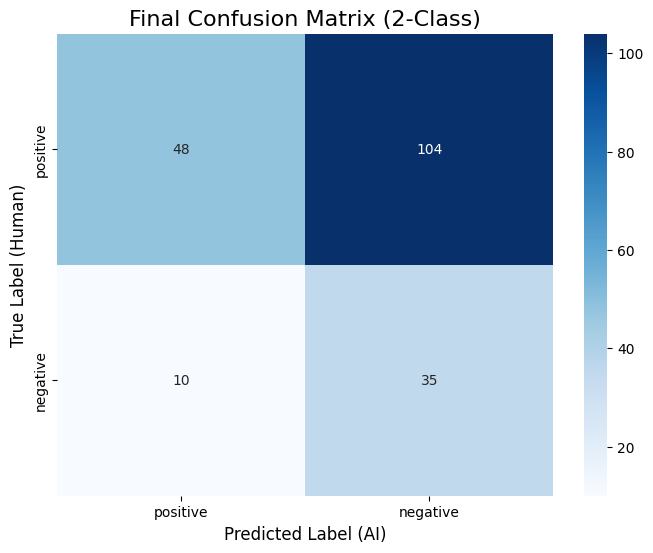

In [29]:
# ==============================================================================
# FINAL VALIDATION: Two-Class Model on Cleaned Data
# ==============================================================================

# --- Setup and Imports ---
print("🚀 Starting Final Validation Workflow...")
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Labeled Data and New Model ---
print("   - Loading data and initializing a 2-class sentiment model...")

LABELED_FILENAME = 'validation_sample_labeled.csv'

try:
    # Check for the necessary labeled file
    if not os.path.exists(LABELED_FILENAME):
        raise FileNotFoundError(f"Please ensure '{LABELED_FILENAME}' is uploaded.")

    df = pd.read_csv(LABELED_FILENAME, encoding='utf-8')
    print(f"   - Original labeled dataset loaded with {len(df)} records.")

    # --- Clean and Filter the DataFrame ---
    # We only want 'positive' and 'negative' rows for this final validation
    df['human_label'] = df['human_label'].astype(str).str.lower()
    df_filtered = df[df['human_label'].isin(['positive', 'negative'])].copy()

    num_removed = len(df) - len(df_filtered)
    print(f"   - Removed {num_removed} non-positive/negative rows.")
    print(f"   - Final clean validation set size: {len(df_filtered)} records.")

    # --- THIS IS THE NEW MODEL ---
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=0
    )
    print("   - 2-Class Sentiment model loaded successfully.")

    # --- Run Model Predictions ---
    def predict_sentiment_binary(text):
        if not isinstance(text, str): return 'negative'
        try:
            result = sentiment_pipeline(text[:512])[0]['label']
            return result.lower()
        except Exception:
            return 'negative'

    print("   - Running model predictions on the clean validation set...")
    df_filtered['model_prediction'] = df_filtered['text_anonymized'].apply(predict_sentiment_binary)
    print("   - Model predictions are complete.\n")

    # --- Calculate and Display Final Metrics ---
    print("✅ Validation process complete. Here are the final results:\n")
    y_true = df_filtered['human_label']
    y_pred = df_filtered['model_prediction']

    # 1. Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("==================================================================")
    print(f"Final Model Accuracy (2-Class): {accuracy:.2%}")
    print("==================================================================\n")

    # 2. Classification Report
    print("--- Final Classification Report ---")
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    # 3. Confusion Matrix
    print("\n--- Final Confusion Matrix ---")
    defined_labels = ['positive', 'negative']
    cm = confusion_matrix(y_true, y_pred, labels=defined_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=defined_labels, yticklabels=defined_labels)
    plt.title('Final Confusion Matrix (2-Class)', fontsize=16)
    plt.ylabel('True Label (Human)', fontsize=12)
    plt.xlabel('Predicted Label (AI)', fontsize=12)
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: A required file was not found. {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")